# Purpose:

2015-02-05 (Thursday)

Provide a way to detect SNP-pairs of a specific distance that are outliers with regard to higher/lower $r^2$ than other SNP-pairs of the same distance.

# Process outline:
1. for each group of SNPs $x$ bp apart: collect $r^2$ from $\pm \sim5$ bp distance window around $x$:
    - across genome
    * across scaffold
2. calculate modified z-score (based on _median absolute deviation_ rather than standard deviation: __MAD is more robust than SD for HTS-type data__)
3. flag any SNP-pair with $z \geq 3.5$
4. possibly randomize data and calculate FDR to evaluate performance.
    a. perhaps vary the window-size from step 1 to use FDR to chose window-size that minimizes FDR.

# Implementation:

## Imports:

In [1]:
# plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import ggplot as gp

In [2]:
import itertools as it
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy
from scikits import bootstrap as bs
import statsmodels.api as sm

import munch

In [3]:
smad = sm.robust.mad

## File paths:

In [4]:
# define paths to files
ld_table = "/home/gus/remote_mounts/louise/data/genomes/glossina_fuscipes/annotations/SNPs/plink_out/tsetseFINAL_14Oct2014_f2_53.recode.renamed_scaffolds.maf0_05.vcf/ld/r_none_freqs_dprime.ld"


In [6]:
ld = pd.read_table(ld_table, sep=" +")
ld['R2'] = ld.R**2
ld['BP_DELTA'] = abs(ld.BP_A - ld.BP_B)

In [7]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156


# Functions based on `2015-01-28_Plot_PLINK_results_cumulative.ipynb`

In [8]:
def get_snps_with_same_distance(df, d, win=100):
    lbound = d - win
    rbound = d + win
    
    if lbound < 0:
        lbound = 0
    
    return df[(df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)]

In [9]:
def get_snps_grouped_by_distances(df, ds, win=100):
    assert isinstance(ds, list)
    assert all([isinstance(d, int) for d in ds])
    
    groups = {}
    
    for d in ds:
        groups[d] = get_snps_with_same_distance(df=df, d=d, win=win)
        
    return groups

In [10]:
def collect_window_stat(df, upper_lim=1000, win=10,
                        stat_name="window_mean_r2", stat_func=np.mean,
                        return_df=True
                       ):
    
    
    data = {stat_name: [], 
            'd': np.array(range(upper_lim))+1}

    
    for d  in data['d']:
        data[stat_name].append(stat_func(get_snps_with_same_distance(df=df, d=d-1, win=win).R2))

    if return_df:
        return pd.DataFrame(data)
    else:
        return data

# Explore data a bit more

In [11]:
snps = get_snps_with_same_distance(df=ld, d=1000, win=0)
snps.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
157887,Scaffold48,467632,.,0.076923,Scaffold48,468632,.,0.103774,-0.099281,1.000000,0.009857,1000
184881,Scaffold117,281622,.,0.405660,Scaffold117,282622,.,0.414894,0.708485,0.740488,0.501951,1000
220859,Scaffold334,125425,.,0.075472,Scaffold334,126425,.,0.117647,-0.106525,1.000000,0.011348,1000
258721,Scaffold1,1713984,.,0.100000,Scaffold1,1714984,.,0.396226,-0.304911,1.000000,0.092971,1000
265848,Scaffold3,2182147,.,0.490566,Scaffold3,2183147,.,0.229167,0.021497,0.038612,0.000462,1000


In [12]:
len(snps)

19

## How many members does each distance group have?

In [13]:
members_per_distance = collect_window_stat(df=ld, upper_lim=1000, win=1,
                                           stat_name="window_members", stat_func=len)

In [14]:
members_per_distance.head()

,d,window_members
0,1,2091
1,2,3631
2,3,5056
3,4,4241
4,5,4040


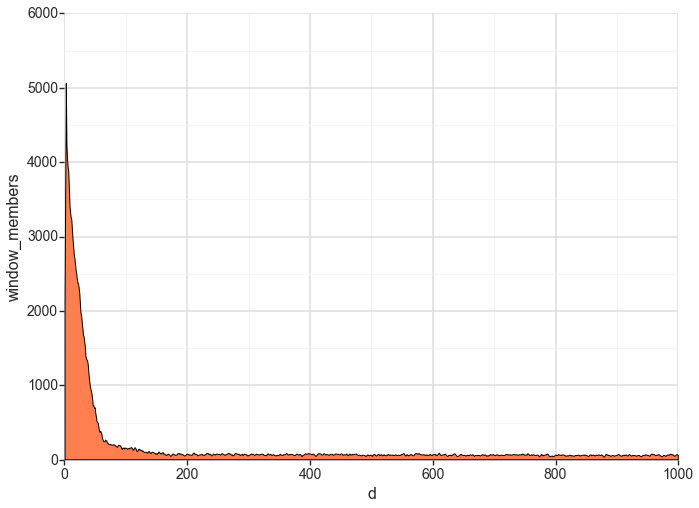

<ggplot: (8759882021253)>

In [15]:
gp.ggplot(gp.aes(x='d', y='window_members', ymin=0, ymax='window_members'), data=members_per_distance) \
+ gp.geom_area(fill='coral') + gp.theme_seaborn(context='talk')

In [16]:
# def bootstrap_choose(X, n=None):
#     """ Bootstrap resample an array_like
#     Parameters
#     ----------
#     X : array_like
#       data to resample
#     n : int, optional
#       length of resampled array, equal to len(X) if n==None
#     Results
#     -------
#     returns X_choices
#     """
#     if n == None:
#         n = len(X)
        
#     choice_i = np.floor(np.random.rand(n)*len(X)).astype(int)
#     X_choices = X[choice_i]
#     return X_choices

# def get_bootstrap_population(X, n=None):
#     pass

def bootstrap_resample(data, num_samples, sample_size=None):
    """Returns bootstrap resample distributions."""
    if sample_size is None:
        sample_size = len(data)
    else:
        assert isinstance(sample_size,int)
        
    
    samples = []
    
    for x in range(num_samples):
        samples.append(np.random.choice(data, size=sample_size))
    return samples
            


    

In [17]:
distance_list = [1,5,10,50,100,500,1000,5000,10000]

In [18]:
snp_groups_by_distance = get_snps_grouped_by_distances(df=ld, ds=distance_list, win=1)

In [19]:
snp_groups_by_distance[10000].BP_DELTA.head()

8012      9999
55896    10000
60879     9999
78750     9999
81524    10000
Name: BP_DELTA, dtype: int64

# How do bootstrap confidence intervals change as distance increases and member numbers decrease?

In [20]:
def get_med_mad_R2_data_for_1_group(df, distance):
    med = munch.Munch()
    mad = munch.Munch()
    
    med.distance = distance
    mad.distance = distance
    
    med.center_type = 'median'
    mad.center_type = 'mad'
    
    med.center = df.R2.median()
    mad.center = sm.robust.mad(df.R2)
    
    med.snp_pairs = len(df.R2)
    mad.snp_pairs = len(df.R2)
    
    med.ci_low, med.ci_high = bs.ci(data=df.R2,
                                    statfunction=np.median,
                                    alpha=0.05,
                                    n_samples=10000,
                                    method='bca',
                                    output='lowhigh'
                                   )

    mad.ci_low, mad.ci_high = bs.ci(data=df.R2, 
                                    statfunction=sm.robust.mad, 
                                    alpha=0.05, 
                                    n_samples=10000, 
                                    method='bca', 
                                    output='lowhigh'
                                   )


    return pd.Series(med), pd.Series(mad)

In [21]:
bootstrap_results_template = \
"""
DISTANCE: {dist}

MEDIAN: {median}
CI: {median_low_ci},{median_hi_ci}
RANGE(MEDIAN): {median_range}

MAD: {mad}
CI: {mad_low_ci},{mad_hi_ci}
RANGE(MAD): {mad_range}
"""

In [22]:
# mm_data = get_med_mad_R2_data_for_1_group(df=snp_groups_by_distance[1],
#                                           distance=1)

# print bootstrap_results_template.format(dist=mm_data[0].distance,
#                                         median=mm_data[0].center,
#                                         median_low_ci=mm_data[0].ci_low,
#                                         median_hi_ci=mm_data[0].ci_high,
#                                         median_range=mm_data[0].ci_high - mm_data[0].ci_low,
                                        
#                                         mad=mm_data[1].center,
#                                         mad_low_ci=mm_data[1].ci_low,
#                                         mad_hi_ci=mm_data[1].ci_high,
#                                         mad_range=mm_data[1].ci_high - mm_data[1].ci_low
#                                        )

In [23]:
# print mm_data

In [24]:
# mm_df = pd.Series(mm_data)
# mm_df

In [25]:
def collect_bootstraps_for_dict(named_distribution_vectors, num_samples):
    
    assert isinstance(named_distribution_vectors, dict)
    assert isinstance(num_samples, int)
    
    bs_dists = {}
    
    for key in named_distribution_vectors.keys():
            bs_dists[key] = bootstrap_resample(data=named_distribution_vectors[key],
                                                    num_samples=num_samples,
                                                    sample_size=None
                                               )
    
    return bs_dists

## Plot how the CIs for median and MAD change with distance

- x-axis: $d$ (distance)
- y-axis: $r^2$ (LD)

1. Convert `mm_data` to `Dataframe` and use the column headers to plot to lines with upper/lower shaded bounds.
2. `ggplot` with two line geoms and correponding fill geoms.

In [26]:
# center_pairs = [get_med_mad_R2_data_for_1_group(df=snp_groups_by_distance[d],
#                                                 distance=d) for d in distance_list
#                 ]

In [27]:
# centers_v_d = pd.DataFrame(list(it.chain.from_iterable(center_pairs)))

In [28]:
# centers_v_d

In [29]:
# dvc = gp.ggplot(gp.aes(x='distance', y='center',
#                        ymin="ci_low", ymax="ci_high",
#                        color='center_type', fill='center_type'
#                       ), 
#                 data=centers_v_d) \
# + gp.scale_color_brewer(type='qual') \
# + gp.theme_seaborn(context='talk') 

# p = dvc + gp.geom_area(alpha=0.3) \
# + gp.geom_line(alpha=1) \
# + gp.scale_x_log10()


# print p;



## Plot how the CIs for median and MAD change with membership (number of snp pairs)




In [30]:
# dvc = gp.ggplot(gp.aes(x='snp_pairs', y='center',
#                        ymin="ci_low", ymax="ci_high",
#                        color='center_type', fill='center_type'
#                       ), 
#                 data=centers_v_d) \
# + gp.scale_color_brewer(type='qual') \
# + gp.theme_seaborn(context='talk') 

# p = dvc + gp.geom_area(alpha=0.3) \
# + gp.geom_line(alpha=1) \
# # + gp.scale_x_log10()


# print p;



In [31]:
d1 = snp_groups_by_distance[1]
d1.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA
126,Scaffold0,111960,.,0.094340,Scaffold0,111961,.,0.198113,0.129084,0.198797,0.016663,1
387,Scaffold0,425425,.,0.320755,Scaffold0,425427,.,0.320755,1.000000,1.000000,1.000000,2
1242,Scaffold0,1379579,.,0.094340,Scaffold0,1379580,.,0.330189,0.459684,1.000000,0.211309,1
1386,Scaffold0,1483974,.,0.198113,Scaffold0,1483975,.,0.235849,0.894690,1.000000,0.800470,1
1413,Scaffold0,1508310,.,0.103774,Scaffold0,1508311,.,0.103774,-0.038305,0.330813,0.001467,1


In [32]:
snp_groups_by_distance[1].BP_DELTA.skew()

0.30718053383413518

In [33]:
bs_per_distance = collect_bootstraps_for_dict(named_distribution_vectors={i:snp_groups_by_distance[i].R2 for i in snp_groups_by_distance.keys()},
                                              num_samples=200)

In [34]:
len(bs_per_distance.values()[0])

200

In [35]:
df_bs_per_distance = pd.DataFrame(bs_per_distance)
df_bs_per_distance.head()

,1,5,10,50,100,500,1000,5000,10000
0,"[0.1236788224, 0.135869646025, 0.019840412736,...","[0.060116664969, 1.0, 0.090620265024, 0.000115...","[0.044538725764, 1.0, 0.946501331689, 1.0, 0.9...","[0.255060351225, 0.905753827521, 0.01113974702...","[0.00263245955625, 0.044262268996, 0.166666429...","[0.035897365156, 0.410801519844, 0.08108085400...","[0.059504284225, 0.004135647481, 0.02733037176...","[0.155250972361, 0.150987422041, 0.04690213176...","[0.053032562944, 0.037631732121, 0.18490086000..."
1,"[1.0, 0.130762515321, 0.722875748841, 0.085038...","[0.043604539489, 1.0, 0.482999980324, 1.0, 0.3...","[0.018234991369, 1.0, 1.0, 0.405405991225, 1.0...","[0.030910562596, 0.536232533841, 0.43023891747...","[0.0223233481, 0.171355430401, 0.0, 0.09574444...","[0.106382954896, 0.062204849281, 0.00564839427...","[0.144168293025, 0.015490540521, 0.01524163084...","[0.00575637829264, 0.0778744836, 0.52016405817...","[0.014005065649, 0.00892597911076, 0.009735176..."
2,"[1.0, 1.0, 1.0, 0.958664224996, 0.250935874225...","[0.012789574281, 1.0, 1.0, 0.890994405625, 0.0...","[1.0, 0.805861699204, 0.145471299649, 0.094017...","[0.107448250849, 0.760181709456, 0.33153182094...","[0.0095238081, 0.063131085081, 0.070840613281,...","[0.0140114569, 0.3993860809, 0.00072562890625,...","[0.759036485529, 0.00827168422144, 0.808823227...","[0.029221851136, 0.155250972361, 0.04690213176...","[0.039844551321, 0.264614561649, 0.01689714012..."
3,"[0.559073234944, 0.714390086656, 1.0, 1.0, 0.0...","[0.340771067536, 0.043171281729, 0.78367287400...","[1.0, 0.00017127480384, 0.788105389009, 0.4059...","[0.111110888889, 0.161392617169, 1.0, 1.0, 0.4...","[1.0, 0.070840613281, 0.036144473689, 0.133333...","[0.150645673161, 0.469774530801, 0.17582423059...","[1.0, 1.0, 0.159950403844, 0.00827168422144, 0...","[0.016260075225, 0.010187066761, 0.04495163232...","[0.016897140121, 0.196236596196, 0.05206017988..."
4,"[1.0, 0.0227527056, 0.058717043856, 1.0, 0.010...","[0.019841257881, 0.794574349321, 0.32616434766...","[0.519722762724, 0.7268926564, 0.9294116836, 1...","[0.080188646976, 0.759595916304, 1.0, 0.010113...","[0.00542426358016, 0.679544679025, 0.002067520...","[0.0525005569, 0.346153369104, 0.123809681956,...","[0.022556435344, 0.00827168422144, 0.040703062...","[0.085755851281, 0.086574235225, 0.0778744836,...","[0.026016077025, 0.00310499700625, 0.063648730..."


In [36]:
x = df_bs_per_distance[1]

In [37]:
x.apply(smad)

0     0.415755
1     0.441138
2     0.372659
3     0.441138
4     0.425410
5     0.504084
6     0.470762
7     0.376745
8     0.469645
9     0.315153
10    0.323366
11    0.476694
12    0.323366
13    0.372659
14    0.429740
...
185    0.429740
186    0.376745
187    0.362349
188    0.387997
189    0.447399
190    0.387158
191    0.380156
192    0.376330
193    0.387602
194    0.303147
195    0.377851
196    0.388040
197    0.379603
198    0.387997
199    0.387757
Name: 1, Length: 200, dtype: float64

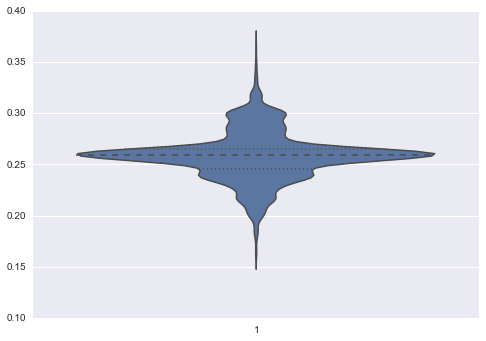

In [38]:
sns.violinplot(sm.robust.mad(bootstrap_resample(d1.R2,10000),1))

-------------

# Implement the modified z-score


Modified z-score ($M_i$) defintion:

$$M_i = \frac{0.6745(x_i-\tilde{x})}{\mathrm{MAD}}$$

Where:

- $x_i$ is the $i^\mathrm{th}$ observation 
- $\tilde{x}$ is the median of the observations
- $\mathrm{MAD}$ is the median absolute deviation.


In [39]:
def modified_z_scores(observations):
    
    M_i = (observations - np.median(observations)) / smad(observations)
    
    return M_i
    

In [40]:
snp_groups_by_distance 
# add column for distance group and concat dfs rather than keeping them in a dict
dfs = []
for k, v in snp_groups_by_distance.iteritems():
    df = v.copy()
    df['distance_group'] = k
    df['modified_z'] = modified_z_scores(df.R2)
    dfs.append(df)
    
df_snp_groups_by_distance = pd.concat(dfs)

In [41]:
df_snp_groups_by_distance.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_group,modified_z
126,Scaffold0,111960,.,0.094340,Scaffold0,111961,.,0.198113,0.129084,0.198797,0.016663,1,1,-1.892288
387,Scaffold0,425425,.,0.320755,Scaffold0,425427,.,0.320755,1.000000,1.000000,1.000000,2,1,0.674490
1242,Scaffold0,1379579,.,0.094340,Scaffold0,1379580,.,0.330189,0.459684,1.000000,0.211309,1,1,-1.384207
1386,Scaffold0,1483974,.,0.198113,Scaffold0,1483975,.,0.235849,0.894690,1.000000,0.800470,1,1,0.153663
1413,Scaffold0,1508310,.,0.103774,Scaffold0,1508311,.,0.103774,-0.038305,0.330813,0.001467,1,1,-1.931952


/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/ggplot.py:200: RuntimeWarning: Facetting is currently not supported with geom_bar. See
                    https://github.com/yhat/ggplot/issues/196 for more information
  warnings.warn(msg, RuntimeWarning)
stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)
/home/gus/.virtualenvs/py279/lib/python2.7/site-packages/ggplot/geoms/geom_bar.py:47: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  _reset = self.bottom == None or (self.ax != None and self.ax != ax)


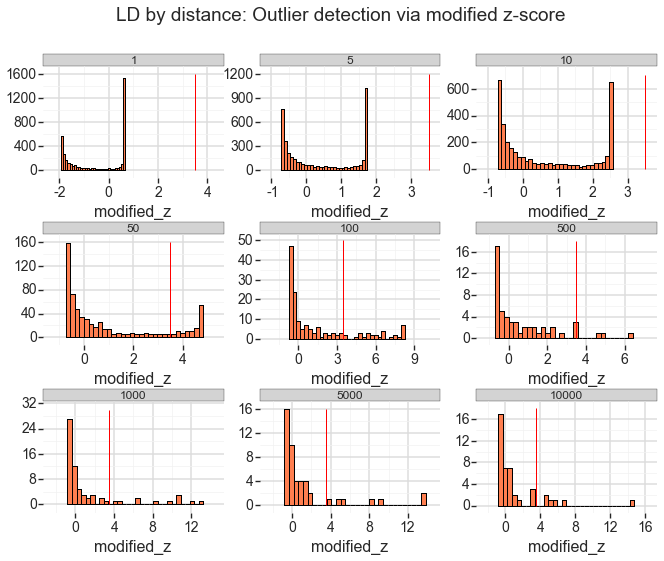

<ggplot: (8759867002225)>

In [42]:
p = gp.ggplot(gp.aes(x='modified_z'), data=df_snp_groups_by_distance)
p + gp.geom_histogram(fill='coral')  + gp.geom_vline(xintercept=[3.5], color='red') + \
    gp.facet_wrap("distance_group") + \
    gp.ggtitle("LD by distance: Outlier detection via modified z-score") + \
    gp.theme_seaborn(context='talk')
    


# Implement non-overlapping bins for z-scores


In [1]:
range(0,100,10)

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90]

In [100]:
def get_snps_in_bin_mask(df, d, win=100):
    
    lbound = d
    rbound = d + win

    return (df.BP_DELTA >= lbound) & (df.BP_DELTA <= rbound)


def update_distance_bin(df, win=100):

    assert isinstance(df, pd.DataFrame)

    # get bin definitions
    longest_d = df.BP_DELTA.max()  # teehee

    ds = xrange(0, longest_d, win)

    # add/overwrite distance_bin column 
    df['distance_bin'] = -1
    
    for d in ds:
        bin_mask = get_snps_in_bin_mask(df=df, d=d, win=win)
        df.loc[bin_mask, 'distance_bin'] = d
    
    # sanity check
    assert df['distance_bin'].min() >= 0

In [101]:
def update_mad_z(df):
    assert isinstance(df, pd.DataFrame)
    
    # add/overwrite mad_z column 
    df['mad_z'] = 'loco'
    
    for d in df.distance_bin.unique():
        d_mask = df.distance_bin == d
        df.loc[d_mask, 'mad_z'] = modified_z_scores(df.R2[d_mask])
        
    # sanity check
    assert 'loco' not in df.mad_z

In [55]:
assert 'b' not in ld.distance_bin

In [102]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,mad_z
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,18.91287
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,18.91287
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,18.91287
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,17.97696
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17100,3.422193


In [97]:
update_distance_bin(ld, win=100)

In [98]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,mad_z
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,18.89918
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,18.89918
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,18.89918
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,17.96407
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17100,3.863787


In [103]:
update_mad_z(ld)

In [104]:
ld.head()

,CHR_A,BP_A,SNP_A,MAF_A,CHR_B,BP_B,SNP_B,MAF_B,R,DP,R2,BP_DELTA,distance_bin,mad_z
0,Scaffold0,13388,.,0.278846,Scaffold0,23408,.,0.298077,1.000000,1,1.000000,10020,10000,18.91287
1,Scaffold0,13388,.,0.278846,Scaffold0,23418,.,0.298077,1.000000,1,1.000000,10030,10000,18.91287
2,Scaffold0,13388,.,0.278846,Scaffold0,23421,.,0.298077,1.000000,1,1.000000,10033,10000,18.91287
3,Scaffold0,13388,.,0.278846,Scaffold0,23431,.,0.288462,0.975946,1,0.952471,10043,10000,17.97696
4,Scaffold0,13388,.,0.278846,Scaffold0,30544,.,0.094340,0.464238,1,0.215517,17156,17100,3.422193


In [105]:
def plot_mad_z_by_bin(df, bins=None):
    assert isinstance(df, pd.DataFrame)
    
    if bins is None:
        plot_mask = np.array([True] * len(df))
    else:
        assert isinstance(bins, (list, tuple))
        
        plot_mask = np.array([False] * len(df))
        for b in bins:
            plot_mask = np.any([plot_mask, (df.distance_bin == b)],0)

    p = gp.ggplot(gp.aes(x='mad_z'), data=df[plot_mask])
    return p + gp.geom_histogram(fill='coral')  + gp.geom_vline(xintercept=[3.5], color='red') + \
               gp.facet_wrap("distance_bin") + \
               gp.ggtitle("LD by distance bin: Outlier detection via modified z-score") + \
               gp.theme_seaborn(context='talk')


In [106]:
bins = sorted(ld.distance_bin.unique())
bins[:10]

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

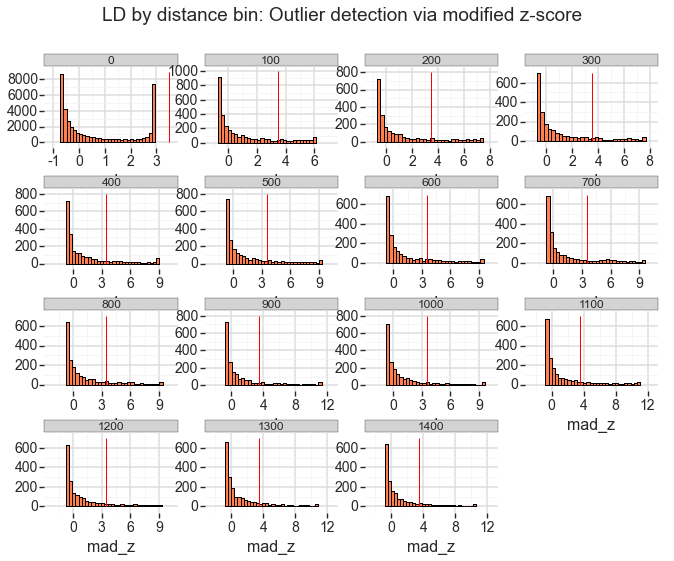

<ggplot: (8759867766689)>

In [108]:
plot_mad_z_by_bin(ld,bins=bins[:15])

In [ ]:
p = gp.ggplot(gp.aes(x='mad_z'), data=ld[ld.distance_bin <= 1000])
p + gp.geom_histogram(fill='coral')  + gp.geom_vline(xintercept=[3.5], color='red') + \
    gp.facet_wrap("distance_bin") + \
    gp.ggtitle("LD by distance bin: Outlier detection via modified z-score") + \
    gp.theme_seaborn(context='talk')

In [ ]:
a = m == 'a'
b = m == 'b'
c = m == 'c'

array([ True,  True,  True, False, False,  True], dtype=bool)

In [82]:
np.all?